In [1]:
!nvidia-smi

Sat Oct 11 05:17:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
data_path = "/content/drive/MyDrive/chatboat/job_intents.json"

In [21]:
# Step 0: Environment + imports + Colab-safe drive mount
import os
import json
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Colab-safe drive mount: attempt to mount if running on Colab, otherwise use cwd
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    data_base_path = '/content/drive/MyDrive/chatboat'
    print("Running on Colab. Using data_base_path =", data_base_path)
except Exception:
    data_base_path = os.getcwd()
    print("Not running on Colab. Using current working directory as data_base_path =", data_base_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on Colab. Using data_base_path = /content/drive/MyDrive/chatboat


In [22]:
# Step 1: data path and NLTK downloads
data_path = os.path.join(data_base_path, 'job_intents.json')

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at: {data_path}\nPlease place job_intents.json in {data_base_path}")

# NLTK resources (download if needed)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
# Step 2: load JSON intents
with open(data_path, 'r', encoding='utf-8') as f:
    intents = json.load(f)


In [24]:
# Step 3: preprocessing: tokenization, lemmatization, collect words/classes/documents
lemmatizer = WordNetLemmatizer()
ignore_words = ['?', '!', '.', ',']

words = []       # all unique words (raw tokens, will lemmatize later)
classes = []     # unique intent tags
documents = []   # list of (tokenized_pattern, tag) tuples

for intent in intents.get('intents', []):
    tag = intent.get('tag')
    for pattern in intent.get('patterns', []):
        tokens = word_tokenize(pattern)
        words.extend(tokens)
        documents.append((tokens, tag))
    if tag not in classes:
        classes.append(tag)

# Lemmatize and lower-case words, remove ignored tokens, deduplicate & sort
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(set(words))
classes = sorted(set(classes))

print("Total unique words:", len(words))
print("Total classes:", len(classes))
print("Total documents:", len(documents))


Total unique words: 50
Total classes: 8
Total documents: 53


In [25]:
# Step 4: create bag-of-words vector function and build training set
def bag_of_words(tokenized_sentence, all_words):
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in tokenized_sentence]
    bag = [1 if w in sentence_words else 0 for w in all_words]
    return np.array(bag, dtype=int)

training = []
output_empty = [0] * len(classes)

for doc in documents:
    pattern_tokens = doc[0]
    tag = doc[1]
    bag = bag_of_words(pattern_tokens, words)
    output_row = output_empty.copy()
    output_row[classes.index(tag)] = 1
    training.append([bag, output_row])


In [26]:
# Step 5: shuffle and split into train_x, train_y
random.shuffle(training)

# --- FIX: use list comprehensions to extract columns (works independent of numpy shape) ---
train_x = [t[0] for t in training]
train_y = [t[1] for t in training]

train_x = np.array(train_x, dtype=float)
train_y = np.array(train_y, dtype=float)

print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)

VALIDATION_SET = (train_x, train_y)


train_x shape: (53, 50)
train_y shape: (53, 8)


In [27]:
# Step 6: Create a simple feed-forward network
input_size = train_x.shape[1]
output_size = train_y.shape[1]

model = Sequential()
model.add(Dense(128, input_shape=(input_size,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_size, activation='softmax'))

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,304 (59.78 KB)

 Trainable params: 15,304 (59.78 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Step 7: Compile the model
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [29]:
# Step 8: Train
history = model.fit(
    train_x,
    train_y,
    epochs=250,
    batch_size=5,
    validation_split=0.2,
    verbose=1
)


Epoch 1/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.2519 - loss: 1.9865 - val_accuracy: 0.1818 - val_loss: 1.9604
Epoch 2/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1363 - loss: 1.9492 - val_accuracy: 0.2727 - val_loss: 1.8827
Epoch 3/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3131 - loss: 1.8117 - val_accuracy: 0.2727 - val_loss: 1.8184
Epoch 4/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3773 - loss: 1.6264 - val_accuracy: 0.2727 - val_loss: 1.7729
Epoch 5/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3981 - loss: 1.4846 - val_accuracy: 0.3636 - val_loss: 1.7257
Epoch 6/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4138 - loss: 1.4699 - val_accuracy: 0.4545 - val_loss: 1.6666
Epoch 7/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4125 - loss: 1.4467 - val_accuracy: 0.4545 - val_loss: 1.6082
Epoch 8/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6269 - loss: 1.2075 - val_accuracy: 0.4545 - val_loss: 1.541

In [30]:
# Step 9: Save model + words/classes + training history
model.save('chatbot_model.h5')
pickle.dump({
    'words': words,
    'classes': classes,
    'history': history.history
}, open('chatbot_data.pkl', 'wb'))

print("Model saved to 'chatbot_model.h5' and data saved to 'chatbot_data.pkl'")


Model saved to 'chatbot_model.h5' and data saved to 'chatbot_data.pkl'


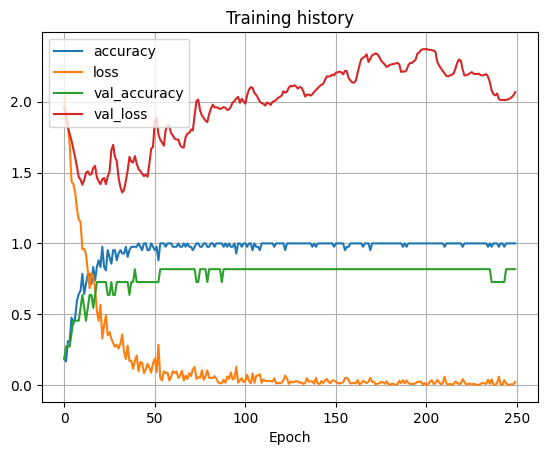

In [31]:
# Step 10: plot history (accuracy/loss)
pd.DataFrame(history.history).plot()
plt.title("Training history")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()
